# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.288763279415448

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.982033241194102

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
x = np.random.exponential(size=sample_size).reshape(-1, 1)

In [7]:
noise = np.random.uniform(-1,1, sample_size).reshape(-1, 1)

In [8]:
y = f(x) + noise

In [9]:
from sklearn import tree
reg = tree.DecisionTreeRegressor()
reg.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [10]:
y_pred = reg.predict(linspace.reshape(-1, 1))

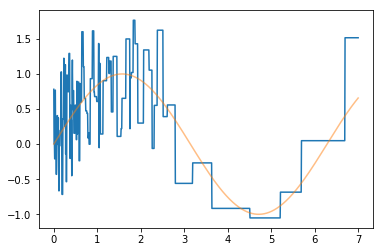

In [11]:
plt.plot(linspace, y_pred,alpha = 1)
plt.plot(linspace, f(linspace),alpha = 0.5)
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

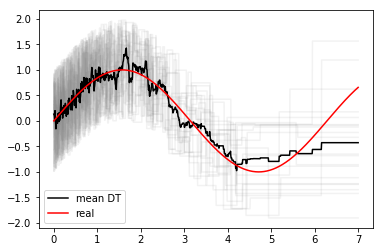

In [13]:
y_pred_mean = 0
for i in range(samples_num):
    x = np.random.exponential(size=sample_size).reshape(-1, 1)
    noize_mc = np.random.uniform(-1, 1, sample_size).reshape(-1, 1)
    y = f(x) + noize_mc

    reg = tree.DecisionTreeRegressor()
    reg.fit(x, y)
    y_pred = reg.predict(linspace.reshape(-1, 1))
    y_pred_mean += y_pred
    plt.plot(linspace, y_pred, color="grey", alpha=0.1)
y_pred_mean = (y_pred_mean/samples_num).reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color = 'black', label='mean DT')
plt.plot(linspace, f(linspace), color = 'red', label='real')
plt.legend()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

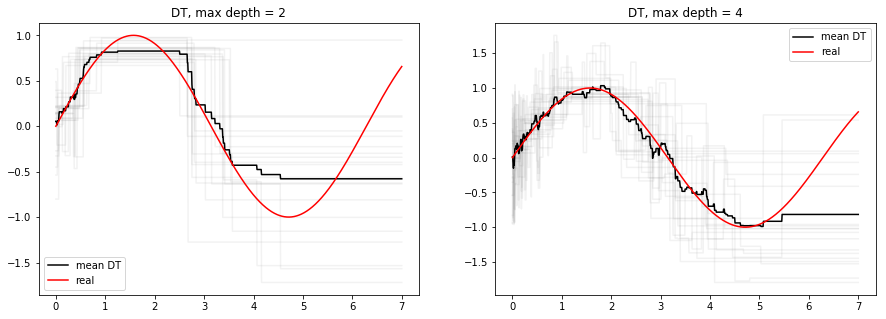

In [14]:
plt.figure(figsize=(15,5))
for m in [2, 4]:
    y_pred_mean = 0
    for i in range(samples_num):
        x = np.random.exponential(size=sample_size).reshape(-1, 1)
        noize_mc = np.random.uniform(-1, 1, sample_size).reshape(-1, 1)
        y = f(x) + noize_mc

        reg = tree.DecisionTreeRegressor(max_depth = m)
        reg.fit(x, y)
        y_pred = reg.predict(linspace.reshape(-1, 1))
        y_pred_mean += y_pred
        plt.subplot(1, 2, m/2)
        plt.plot(linspace, y_pred, color="grey", alpha=0.1)
    y_pred_mean = (y_pred_mean/samples_num).reshape(-1, 1)
    plt.subplot(1, 2, m/2)
    plt.plot(linspace, y_pred_mean, color = 'black', label='mean DT')
    plt.plot(linspace, f(linspace), color = 'red', label='real')
    plt.legend()
    plt.title('DT, max depth = ' + str(m))

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Смещение увеличивается по мере уменьшения допустимой глубины дерева. В нашем случае максимальное смещение получается при max_depth=2, так как без ограничения максимальной глубины, как в 1 случае, она может быть очень большой (в случае если нет других ограничений, как минимальное количество объектов в листе и др).

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

C:\Users\Yulia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


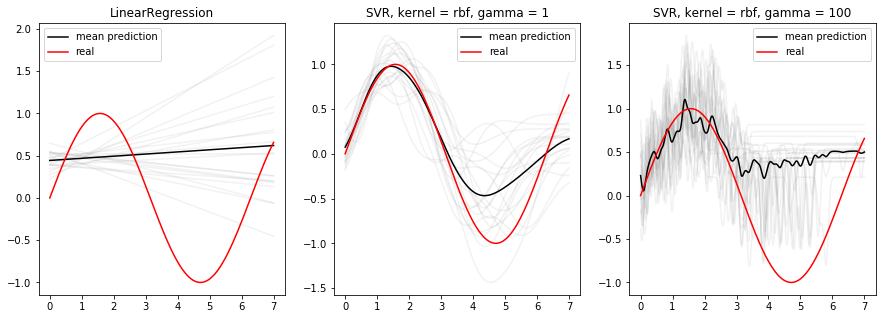

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

reg1 = LinearRegression()
reg2 = SVR(kernel = 'rbf', gamma = 1)
reg3 = SVR(kernel = 'rbf', gamma = 100)
reg_list5 = [reg1, reg2, reg3]
reg_names = ['LinearRegression', 'SVR, kernel = rbf, gamma = 1', 'SVR, kernel = rbf, gamma = 100']
plt.figure(figsize=(15,5))
for m in range(3):
    y_pred_mean = 0
    
    for i in range(samples_num):
        x = np.random.exponential(size=sample_size).reshape(-1, 1)
        noize_mc = np.random.uniform(-1, 1, sample_size).reshape(-1, 1)
        y = f(x) + noize_mc

        reg = reg_list5[m]
        reg.fit(x, y)
        y_pred = reg.predict(linspace.reshape(-1, 1))
        y_pred_mean += y_pred
        plt.subplot(1, 3, m+1)
        plt.plot(linspace, y_pred, color="grey", alpha=0.1)
        
    y_pred_mean = (y_pred_mean/samples_num).reshape(-1, 1)
    
    plt.subplot(1, 3, m+1)
    plt.plot(linspace, y_pred_mean, color = 'black', label='mean prediction')
    plt.plot(linspace, f(linspace), color = 'red', label='real')
    plt.legend()
    plt.title(reg_names[m])

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [37]:
mush = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header = None)
tic = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header = None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
nur = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header = None)

In [38]:
cv = ShuffleSplit(n_splits= 10, test_size=0.3, random_state=42)

Датасет с грибами

In [39]:
y = mush[0]
x = mush.drop(0, 1)

dum = pd.get_dummies(x)

le = LabelEncoder()
y = le.fit_transform(y)

for i in range(len(x.columns)):
    x[i+1] = le.fit_transform(x[i+1])

Если все признаки - категориальные

In [41]:
cross_val_score(estimator = DecisionTreeClassifier(), 
                scoring = make_scorer(accuracy_score), X = dum, y = y, cv = cv).mean()

1.0

Если все признаки - вещественные

In [40]:
cross_val_score(estimator = DecisionTreeClassifier(),
                scoring = make_scorer(accuracy_score), X = x, y = y, cv = cv).mean()

1.0

Датасет с тик рак тое

In [44]:
y = tic[9]
x = tic.drop(9, 1)

dum = pd.get_dummies(x)


le.fit(y)
y = le.fit_transform(y)

for i in range(len(x.columns)):
    x[i] = le.fit_transform(x[i])

Если все признаки - категориальные

In [45]:
cross_val_score(estimator = DecisionTreeClassifier(), 
                scoring = make_scorer(accuracy_score), X = dum, y = y, cv = cv).mean()

0.92534722222222232

Если все признаки - вещественные

In [46]:
cross_val_score(estimator = DecisionTreeClassifier(), 
                scoring = make_scorer(accuracy_score), X = x, y = y, cv = cv).mean()

0.87430555555555556

Датасет с машинами

In [48]:
y = cars[6]
x = cars.drop(6, 1)

dum = pd.get_dummies(x)

y[y.isin(['acc', 'unacc'])] = 0
y[y.isin(['good', 'vgood'])]= 1

cars_correct = x.copy()

cars_correct[cars_correct.isin(['low', 'small'])] = 0
cars_correct[cars_correct.isin(['med'])] = 1
cars_correct[cars_correct.isin(['high', 'big'])] = 2
cars_correct[cars_correct.isin(['vhigh'])] = 3
cars_correct[cars_correct.isin(['more', '5more'])] = 5

for i in range(len(x.columns)):
    x[i] = le.fit_transform(x[i])

Если все признаки - категориальные

In [49]:
cross_val_score(estimator = DecisionTreeClassifier(),scoring = make_scorer(accuracy_score),
                X = np.array(dum, dtype = 'int'), y = np.array(y, dtype = 'int'), cv = cv).mean()

0.98477842003853566

Если все признаки - вещественные

In [50]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = np.array(x, dtype = 'int'), y = np.array(y, dtype = 'int'), cv = cv).mean()

0.98882466281310211

Если все признаки - с корректным разбиением

In [51]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X=np.array(cars_correct, dtype = 'int'), y = np.array(y, dtype = 'int'), cv = cv).mean()

0.98921001926782259

Датасет с нерсери

In [53]:
y = nur[8]
x = nur.drop(8, 1)

dum = pd.get_dummies(x)

y[y.isin(['not_recom', 'recommend'])] = 0
y[y.isin(['very_recom', 'priority', 'spec_prior'])] = 1

nur_correct = x.copy()


nur_correct[0][nur_correct[0] == 'usual'] = 0
nur_correct[0][nur_correct[0] == 'pretentious'] = 1
nur_correct[0][nur_correct[0] == 'great_pret'] = 2
nur_correct[1][nur_correct[1] == 'very_crit'] = 0
nur_correct[1][nur_correct[1] == 'critical'] = 1
nur_correct[1][nur_correct[1] == 'improper'] = 2
nur_correct[1][nur_correct[1] == 'less_proper'] = 3
nur_correct[1][nur_correct[1] == 'proper'] = 4
nur_correct[2][nur_correct[2] == 'complete'] = 0
nur_correct[2][nur_correct[2] == 'completed'] = 1
nur_correct[2][nur_correct[2] == 'incomplete'] = 2
nur_correct[2][nur_correct[2] == 'foster'] = 3
nur_correct[3][nur_correct[3] == 'more'] = 4
nur_correct[4][nur_correct[4] == 'critical'] = 0
nur_correct[4][nur_correct[4] == 'less_conv'] = 1
nur_correct[4][nur_correct[4] == 'convenient'] = 2
nur_correct[5][nur_correct[5] == 'inconv'] = 0
nur_correct[5][nur_correct[5] == 'convenient'] = 1
nur_correct[6][nur_correct[6] == 'problematic'] = 0
nur_correct[6][nur_correct[6] == 'slightly_prob'] = 1
nur_correct[6][nur_correct[6] == 'nonprob'] = 2
nur_correct[7][nur_correct[7] == 'not_recom'] = 0
nur_correct[7][nur_correct[7] == 'recommended'] = 1
nur_correct[7][nur_correct[7] == 'priority'] = 2

for i in range(len(x.columns)):
    x[i] = le.fit_transform(x[i])

Если все признаки - категориальные

In [54]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = np.array(dum, dtype = 'int'), y = np.array(y, dtype = 'int'), cv = cv).mean()

0.99976851851851833

Если все признаки - вещественные

In [55]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = np.array(x, dtype = 'int'), y = np.array(y, dtype = 'int'), cv = cv).mean()

0.99969135802469133

Если все признаки - с корректным разбиением

In [56]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = np.array(nur_correct, dtype = 'int'), y = np.array(y, dtype = 'int'), cv = cv).mean()

0.99979423868312745

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

На датасете с грибами оба алгоритма работают одинаково хорошо. В случае датасета тик рак тое алгоритм с категориальными признаками дает лучше результат, так как в данных есть категориальные признаки. С двумя последними датасетами лучший результат показывает алгоритм с корректным разбиением признаков. Значит, нужно выбирать наиболее подходящий алгоритм для типа признаков в наших данных. 


### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [59]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [62]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
y = df['quality']
x = df.drop('quality', 1)

cv = ShuffleSplit(n_splits= 3, test_size=0.3, random_state = 42)

In [63]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = x, y = Y, cv = cv).mean()

0.56388888888888877

In [64]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score),
                X = x, y = Y, cv = cv).mean()

0.6465277777777777

In [65]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100, max_features = 0.5), scoring = make_scorer(accuracy_score),\
                X = x, y = Y, cv = cv).mean()

0.65972222222222221

In [66]:
cross_val_score(estimator = RandomForestClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score),
                X = x, y = Y, cv = cv).mean()

0.66180555555555554

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [67]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [68]:
x, y = shuffle(x, y, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [69]:
clf = RandomForestClassifier(n_estimators = 99,  warm_start = True, random_state = 42)
score = []
X = []
for i in np.arange(100,5000, 100):
    clf.set_params(n_estimators = i)

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score.append(accuracy_score(y_test, y_pred))
    X.append(i)

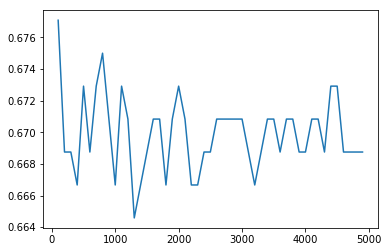

In [70]:
plt.plot(X, score)

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 